<a href="https://colab.research.google.com/github/Le4o/topicos-avancados-ic/blob/main/Avalia%C3%A7%C3%A3o_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Séries Temporais
#### Exercício da matéria de Tópicos Avançados em Inteligência Computacional

Grupo:
- João Victor de Sledz Bulhões
- Leonardo de Andrade Santana
- Lis da Silva Azevedo

### Definição do Exercício
Utilizaremos o banco de dados do Human Activity Recognition with Smartphones, que foi construído a partir das gravações dos participantes do estudo realizando atividades da vida diária enquanto carregavam um smartphone com sensores inerciais embutidos. Para cada registro no conjunto de dados, é fornecido:

- Aceleração triaxial do acelerômetro (aceleração total) e a aceleração corporal estimada.

- Velocidade angular triaxial do giroscópio.

- Um vetor de 561 atributos com variáveis de domínio de tempo e frequência.

- O rótulo da atividade.

### Objetivo:
* Construir um modelo robusto para classificação das atividades diárias, utilizando o banco de dados fornecido, em uma das seis ações disponíveis:
> 1. caminhar;
> 2. subir escadas;
> 3. descer escadas;
> 4. sentar;
> 5. ficar em pé;
> 6. deitar.

* Desenvolver 4 modelos, utilizando:
> 1. Multi-Layer Perceptron (MLP)
> 2. Convolutional Neural Network (CNN)
> 3. Recurrent Neural Network (RNN)
> 4. Arquitetura hibrida com a combinação das redes anteriore

* Considere a divisão entre treinamento, validação e teste de 50%, 25% e 25%, respectivamente.

* Utilizar como métricas: **precision, recall, specificity,
F1-Score e accuracy**, evidenciando que o modelo não sofreu de **over/underfitting**.

### Observação: 
*   *Apresentação de métricas, gráficos, são essenciais para entendimento dos modelos e justificativas.*
*   *Compare ao final em uma tabela e apresente que técnica obteve os melhores
resultados, discutindo-os à luz de seu conhecimento sobre o assunto, discutindo
se eram resultados esperados, se estão adequados, e os porquês.*

### Opcionais:

*   A utilização de redes neurais baseadas em transformers é opcional e adicionará **1,0 ponto extra** ao projeto.
*   A utilização de pré-processamento das séries com Wavelets OU transformadas de Fourier adicionará **1,0 ponto extra** ao projeto.


### Link:

* [Mais informações sobre os recursos estão disponíveis no site](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) 


In [23]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Datasets

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Datasets


In [82]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.layers.convolutional import Conv1D
from tensorflow.keras.layers import Dense, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

## Carregando os dados

O dataset fornecido é segmentado em **70% treino e 30% teste**, porém a atividade pede para segmentar em: **50% treino, 25% validação e 25% teste.** Então nos primeiramente juntamos os dados.


In [25]:
# Carregando os dados diretamente dos csvs do Human Activity Recognition with Smartphones
train_data = pd.read_csv('./uci_har_csvs/train.csv')
test_data = pd.read_csv('./uci_har_csvs/test.csv')

print(f'Shape of train data is: {train_data.shape}\nShape of test data is: {test_data.shape}')

data = train_data.append(test_data)
data.shape

print(f'Shape of combined data is {data.shape}')

Shape of train data is: (7352, 563)
Shape of test data is: (2947, 563)
Shape of combined data is (10299, 563)


## Analise inicial dos dados

O dataset possui 6 classes, sendo elas:


1.   Walking downstairs
2.   Walking Upstairs
3.   Walking
4.   Sitting
5.   Stading 
6.   Laying



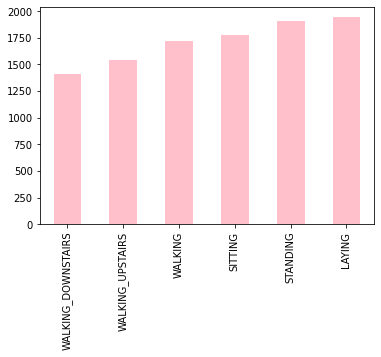

In [26]:
class_count = len(data['Activity'].unique())
data['Activity'].value_counts().sort_values().plot(kind = 'bar', color = 'pink')

## Segmentação do Dataset

50% treino, 25% validação e 25% teste


In [62]:
train, validate, test = \
              np.split(data.sample(frac=1, random_state=42), 
                       [int(.5*len(data)), int(.75*len(data))])
              
print(f'Shape of train data is {train.shape}')
print(f'Shape of validation data is {validate.shape}')
print(f'Shape of test data is {test.shape}')
validate.head()

Shape of train data is (5149, 563)
Shape of validation data is (2575, 563)
Shape of test data is (2575, 563)


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
2117,0.274369,-0.016706,-0.110229,-0.991515,-0.989040,-0.978536,-0.992510,-0.990249,-0.980843,-0.936067,-0.561457,-0.812424,0.841441,0.691739,0.824627,-0.989752,-0.999926,-0.999935,-0.999490,-0.994133,-0.991564,-0.983694,-0.570835,-0.632256,-0.525435,0.194450,-0.146492,-0.041534,0.385220,0.146668,0.008702,0.117522,0.316987,0.049494,0.002990,0.077043,-0.040535,-0.326617,-0.124434,-0.467705,...,-1.000000,-1.000000,0.189798,-0.435028,-0.826468,-0.983336,-0.983446,-0.979036,-0.988786,-0.996133,-0.983336,-0.999768,-0.973804,-0.651509,-1.0,-0.200696,-0.692462,-0.925401,-0.990613,-0.989842,-0.989335,-0.990264,-0.995010,-0.990613,-0.999922,-0.988997,-0.923452,-1.000000,-0.165418,-0.227327,-0.592258,-0.031017,-0.068529,0.222656,-0.171256,0.365294,-0.846661,-0.004809,11,LAYING
2937,0.260018,-0.008491,-0.117588,-0.935685,-0.670521,-0.875247,-0.959882,-0.805597,-0.907493,-0.892596,-0.146449,-0.774665,0.710398,0.541556,0.691246,-0.910007,-0.997606,-0.978016,-0.991313,-0.995422,-0.989595,-0.963853,-0.310086,-0.398456,-0.248864,-0.508756,0.476951,-0.460860,0.392226,-0.604299,0.591770,-0.713939,0.839213,-0.252033,0.355529,-1.000000,1.000000,0.296486,-0.012320,-0.867214,...,-0.476360,-1.000000,-0.455206,0.384570,0.087227,-0.512505,-0.269562,-0.408939,-0.192944,-0.049099,-0.512505,-0.740628,-0.801698,0.130729,-1.0,-0.259452,0.265055,-0.064927,-0.929913,-0.863376,-0.907363,-0.843969,-0.985603,-0.929913,-0.993913,-0.935197,-0.419270,-1.000000,-0.563006,0.783258,0.551519,0.351286,0.079468,0.329166,0.006809,-0.885412,0.113755,0.100170,16,SITTING
6867,0.278964,-0.016177,-0.112617,-0.986395,-0.993402,-0.996253,-0.987809,-0.994375,-0.995559,-0.935219,-0.566172,-0.826331,0.838379,0.692073,0.845662,-0.992035,-0.999849,-0.999965,-0.999920,-0.989898,-0.995405,-0.992992,-0.391655,-0.668624,-0.735404,0.074098,-0.024003,-0.086759,-0.050424,0.497133,-0.308945,0.436123,-0.284634,0.562480,-0.303941,0.243113,-0.238292,-0.560531,-0.482763,0.529234,...,-1.000000,-0.746032,0.201563,-0.661723,-0.919496,-0.963026,-0.936948,-0.955237,-0.922671,-0.973526,-0.963026,-0.998002,-0.980297,-0.

## Preparando os Dados para os Modelos

*   **x** = Todos os conjuntos de dados tirando as duas ultimas colunas.
*   **y** = Ultima coluna, coluna que define a atividade.



In [173]:
# Separando os os dados do target
x_train, y_train = train.iloc[:, :-2], train.iloc[:, -1:]
x_validate, y_validate = validate.iloc[:, :-2], validate.iloc[:, -1:]
x_test, y_test = test.iloc[:, :-2], test.iloc[:, -1:]
print(f'Train: {x_train.shape}, {y_train.shape}\nValidation: {x_validate.shape}, {y_validate.shape}\nTraining: {x_test.shape}, {y_test.shape}\n')

Train: (5149, 561), (5149, 1)
Validation: (2575, 561), (2575, 1)
Training: (2575, 561), (2575, 1)



Os modelos aceitam apenas números, então foi necessário alterar as strings que definem as classes para números.

In [174]:
# Trasformando as strings do target em números
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_validate = le.fit_transform(y_validate)
y_test = le.fit_transform(y_test)

# --------------Não sei oq é isso
scaling_data = MinMaxScaler()
x_train = scaling_data.fit_transform(x_train)
x_validate = scaling_data.fit_transform(x_validate)
x_test = scaling_data.transform(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Multi-Layer Perceptron (MLP)

Perceptron é utilizado para classificação binária, possuindo apenas 1 neurônio, sendo assim, não podendo se aplicar a dados não lineares. 
O MLP foi desenvolvido para suprir com essa limitação.Ele possui camadas de entrada e saída e uma ou mais camadas ocultas com muitos neurônios juntos. E enquanto no Perceptron o neurônio deve ter uma função de ativação que impõe um limite, como ReLU ou sigmoid, os neurônios em um MLP podem usar qualquer função de ativação arbitrária.

Funções de ativação: 
*   **ReLU**: Função não linear que a não ativa todos os neurônios ao mesmo tempo. Se a entrada for negativa, ela será convertida em zero e o neurônio não será ativado. Isso significa que, ao mesmo tempo, apenas alguns neurônios são ativados, tornando a rede esparsa e eficiente e fácil para a computação.
*   **Softmax**: Alternativa para função sigmóide para lidar com problemas de classificação, já que a mesma é capaz de lidar com mais de 2 classes, diferente da sigmóide.




In [65]:
# Criando o model
model_mlp = Sequential()
model_mlp.add(Dense(64, activation='relu', input_dim=x_train.shape[1])) # Layer 1
model_mlp.add(Dropout(0.5))
model_mlp.add(Dense(64, activation='relu')) # Layer 2
model_mlp.add(Dropout(0.5))
model_mlp.add(Dense(10, activation='softmax')) # Layer 3



*   **Compilação, Treino e validação**: O processo de treino foi composto por 20 epocas e 50% do dataset e a validação por 25% do dataset. 
>* Optimizer: [**Adam**](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) é um algoritmo de otimização que pode ser usado em vez do procedimento clássico de *Stochastic Gradient Descent* (mantém uma única taxa de aprendizado para todas as atualizações de peso e a taxa de aprendizado não muda durante o treinamento) para atualizar os pesos da rede iterativos com base nos dados de treinamento.
>* Loss: [sparse_categorical_crossentropy](https://vitalflux.com/keras-categorical-cross-entropy-loss-function/) Usado para modelos de classificação multi-classes quando a output label  sao valores inteiros (0, 1, 2,..).


In [66]:
# Compilando o model e treinando
model_mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # optimizer 'adam'
history = model_mlp.fit(x_train, y_train, batch_size=64, epochs=20, validation_data=(x_validate, y_validate)) # teinando e validando 

Epoch 1/20
81/81 [==============================] - 1s 6ms/step - loss: 1.5931 - accuracy: 0.3531 - val_loss: 0.9102 - val_accuracy: 0.7398
Epoch 2/20
81/81 [==============================] - 0s 5ms/step - loss: 0.9931 - accuracy: 0.5605 - val_loss: 0.6210 - val_accuracy: 0.7685
Epoch 3/20
81/81 [==============================] - 0s 4ms/step - loss: 0.7319 - accuracy: 0.6762 - val_loss: 0.5047 - val_accuracy: 0.8101
Epoch 4/20
81/81 [==============================] - 0s 4ms/step - loss: 0.6035 - accuracy: 0.7318 - val_loss: 0.4017 - val_accuracy: 0.8559
Epoch 5/20
81/81 [==============================] - 0s 4ms/step - loss: 0.5330 - accuracy: 0.7720 - val_loss: 0.3463 - val_accuracy: 0.8707
Epoch 6/20
81/81 [==============================] - 0s 4ms/step - loss: 0.4505 - accuracy: 0.8079 - val_loss: 0.3097 - val_accuracy: 0.8664
Epoch 7/20
81/81 [==============================] - 0s 4ms/step - loss: 0.4106 - accuracy: 0.8320 - val_loss: 0.2783 - val_accuracy: 0.8816
Epoch 8/20
81/81 [==

Testando o modelo com dataset de teste que equivale 50% do dataset total

In [76]:
# Testando o model após treinamento
test_results = model_mlp.evaluate(x_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

81/81 [==============================] - 0s 2ms/step - loss: 0.1201 - accuracy: 0.9588
Test results - Loss: 0.12012684345245361 - Accuracy: 0.9588349461555481%


# Convolutional Neural Network (CNN)
Uma **Artificial Neural Network (ANN)** é uma série de algoritmos que se esforçam para reconhecer relacionamentos subjacentes em um conjunto de dados, por meio de um processo que imita a maneira como o cérebro humano opera. As **ANN** podem se adaptar a mudanças de entrada para que a rede gere o melhor resultado possível sem a necessidade de redesenhar os critérios de saída.

As **Convolutional Neural Network (CNN)** são um tipo especializado de ANN que usam convolução no lugar da multiplicação geral da matriz em pelo menos uma de suas camadas.

In [97]:
n_timesteps, n_features, n_outputs = x_train.shape[0], x_train.shape[1], y_train.shape[0]

# Adicionando mais uma dimensão a x, para ficarem 3, como é pedido no Conv1D
x_train_cnn = x_train[..., None]
x_validate_cnn = x_validate[..., None]

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=x_train_cnn.shape[1:]))
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(10, activation='softmax'))

model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model_cnn.fit(x_train_cnn, y_train, batch_size=64, epochs=20, validation_data=(x_validate_cnn, y_validate))

Epoch 1/20
81/81 [==============================] - 11s 127ms/step - loss: 0.8098 - accuracy: 0.6613 - val_loss: 0.4605 - val_accuracy: 0.8454
Epoch 2/20
81/81 [==============================] - 10s 124ms/step - loss: 0.2635 - accuracy: 0.8990 - val_loss: 0.2499 - val_accuracy: 0.9025
Epoch 3/20
81/81 [==============================] - 10s 124ms/step - loss: 0.1557 - accuracy: 0.9443 - val_loss: 0.1429 - val_accuracy: 0.9557
Epoch 4/20
81/81 [==============================] - 10s 124ms/step - loss: 0.1398 - accuracy: 0.9448 - val_loss: 0.1465 - val_accuracy: 0.9441
Epoch 5/20
81/81 [==============================] - 10s 125ms/step - loss: 0.0987 - accuracy: 0.9643 - val_loss: 0.0989 - val_accuracy: 0.9666
Epoch 6/20
81/81 [==============================] - 10s 125ms/step - loss: 0.1046 - accuracy: 0.9590 - val_loss: 0.1497 - val_accuracy: 0.9394
Epoch 7/20
81/81 [==============================] - 10s 124ms/step - loss: 0.1033 - accuracy: 0.9604 - val_loss: 0.1470 - val_accuracy: 0.9441

In [98]:
# Testando o model após treinamento
x_test_cnn = x_test[..., None]
test_results = model_cnn.evaluate(x_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

81/81 [==============================] - 1s 15ms/step - loss: 0.0771 - accuracy: 0.9678
Test results - Loss: 0.07712676376104355 - Accuracy: 0.9677670001983643%


# Recurrent Neural Network (RNN)

**Recurrent Neural Network (RNN)** tem uma conexão recorrente no *hidden state*. Essa restrição de loop garante que as informações sequenciais sejam capturadas nos dados de entrada.

In [168]:
x_train_rnn = x_train[..., None]
x_validate_rnn = x_validate[..., None]

model_rnn2 = keras.models.Sequential()
model_rnn2.add(keras.Input(shape=x_train_rnn.shape[1:])) 
model_rnn2.add(layers.SimpleRNN(128, return_sequences=True, activation='relu'))
model_rnn2.add(Flatten())
model_rnn2.add(layers.Dense(10))

model_rnn2.summary()

(5149, 561, 1)
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_12 (SimpleRNN)   (None, 561, 128)          16640     
                                                                 
 flatten_20 (Flatten)        (None, 71808)             0         
                                                                 
 dense_130 (Dense)           (None, 10)                718090    
                                                                 
Total params: 734,730
Trainable params: 734,730
Non-trainable params: 0
_________________________________________________________________


In [169]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]

model_rnn2.compile(loss=loss, optimizer=optim, metrics=metrics)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [170]:
model_rnn2.fit(
    x_train_rnn, y_train, validation_data=(x_validate_rnn, y_validate), batch_size=64, epochs=10
)

Epoch 1/10
81/81 [==============================] - 23s 270ms/step - loss: 0.4360 - accuracy: 0.8194 - val_loss: 0.1771 - val_accuracy: 0.9243
Epoch 2/10
81/81 [==============================] - 22s 270ms/step - loss: 0.1289 - accuracy: 0.9503 - val_loss: 0.1358 - val_accuracy: 0.9429
Epoch 3/10
81/81 [==============================] - 22s 270ms/step - loss: 0.0735 - accuracy: 0.9720 - val_loss: 0.0765 - val_accuracy: 0.9736
Epoch 4/10
81/81 [==============================] - 22s 268ms/step - loss: 0.0638 - accuracy: 0.9765 - val_loss: 0.0839 - val_accuracy: 0.9701
Epoch 5/10
81/81 [==============================] - 22s 270ms/step - loss: 0.0515 - accuracy: 0.9821 - val_loss: 0.0986 - val_accuracy: 0.9612
Epoch 6/10
81/81 [==============================] - 22s 271ms/step - loss: 0.0577 - accuracy: 0.9779 - val_loss: 0.0982 - val_accuracy: 0.9604
Epoch 7/10
81/81 [==============================] - 22s 274ms/step - loss: 0.0336 - accuracy: 0.9880 - val_loss: 0.0686 - val_accuracy: 0.9771

In [172]:
model_rnn2.evaluate(x_test, y_test, batch_size=64, verbose=2)

41/41 - 4s - loss: 0.0759 - accuracy: 0.9740 - 4s/epoch - 88ms/step


[0.07594688981771469, 0.9739806056022644]

# Modelo Híbrido
Criando modelo híbrido

In [175]:
x_train = x_train[..., None]
x_validate = x_validate[..., None]

model_hyb = Sequential()
# Model RNN
model_hyb.add(keras.Input(shape=x_train_rnn.shape[1:])) 
model_hyb.add(layers.SimpleRNN(128, return_sequences=True, activation='relu'))
# Model CNN
model_hyb.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model_hyb.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model_hyb.add(Dropout(0.5))
model_hyb.add(MaxPooling1D(pool_size=2))
model_hyb.add(Flatten())
# Model MLP
model_hyb.add(Dense(64, activation='relu')) # Layer 1
model_hyb.add(Dropout(0.5))
model_hyb.add(Dense(64, activation='relu')) # Layer 2
model_hyb.add(Dropout(0.5))
model_hyb.add(Dense(10, activation='softmax'))

model_hyb.summary()

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_13 (SimpleRNN)   (None, 561, 128)          16640     
                                                                 
 conv1d_49 (Conv1D)          (None, 560, 64)           16448     
                                                                 
 conv1d_50 (Conv1D)          (None, 559, 64)           8256      
                                                                 
 dropout_73 (Dropout)        (None, 559, 64)           0         
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 279, 64)          0         
 g1D)                                                            
                                                                 
 flatten_21 (Flatten)        (None, 17856)             0         
                                                     

In [176]:
model_hyb.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model_hyb.fit(x_train, y_train, batch_size=64, epochs=20, validation_data=(x_validate, y_validate))

Epoch 1/20
81/81 [==============================] - 38s 460ms/step - loss: 1.6232 - accuracy: 0.3484 - val_loss: 0.7208 - val_accuracy: 0.7984
Epoch 2/20
81/81 [==============================] - 37s 456ms/step - loss: 0.8176 - accuracy: 0.6564 - val_loss: 0.3642 - val_accuracy: 0.8808
Epoch 3/20
81/81 [==============================] - 37s 454ms/step - loss: 0.5569 - accuracy: 0.7609 - val_loss: 0.2314 - val_accuracy: 0.9142
Epoch 4/20
81/81 [==============================] - 37s 456ms/step - loss: 0.4441 - accuracy: 0.8157 - val_loss: 0.1939 - val_accuracy: 0.9344
Epoch 5/20
81/81 [==============================] - 37s 455ms/step - loss: 0.3685 - accuracy: 0.8458 - val_loss: 0.1631 - val_accuracy: 0.9437
Epoch 6/20
81/81 [==============================] - 37s 457ms/step - loss: 0.3160 - accuracy: 0.8699 - val_loss: 0.1688 - val_accuracy: 0.9239
Epoch 7/20
81/81 [==============================] - 37s 456ms/step - loss: 0.3045 - accuracy: 0.8811 - val_loss: 0.1104 - val_accuracy: 0.9573

In [178]:
# Testando o model após treinamento
x_test_rnn2 = x_test[..., None]
test_results = model_hyb.evaluate(x_test_rnn2, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

81/81 [==============================] - 6s 75ms/step - loss: 0.0811 - accuracy: 0.9705
Test results - Loss: 0.08111096173524857 - Accuracy: 0.9704854488372803%


# Conclusão



![image.png](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/02/table.png)